# Assignment 7 
## Objective
Build a Long Short-Term Memory (LSTM) recurrent neural network to predict the current global active power at the time step (t), given prior measurements at the time step (t-1).

# Recurrent Neural Network

## Part 1 - Data Preprocessing

### Importing the libraries

In [100]:
# Import required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

### Importing the training set

In [101]:
# Load the dataset
df_original = pd.read_csv('household_power_consumption.txt', sep=';', 
                            parse_dates={'DateTime': ['Date', 'Time']}, 
                            infer_datetime_format=True, 
                            low_memory=False,  # Prevent type inference issues
                            na_values=['?'])   # Treat '?' as NaN

# Cut the data for training time purposes
df = df_original.iloc[:100000]

# Display the first few rows
print("Dataset head:")
display(df.info())

Dataset head:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   DateTime               100000 non-null  datetime64[ns]
 1   Global_active_power    99992 non-null   float64       
 2   Global_reactive_power  99992 non-null   float64       
 3   Voltage                99992 non-null   float64       
 4   Global_intensity       99992 non-null   float64       
 5   Sub_metering_1         99992 non-null   float64       
 6   Sub_metering_2         99992 non-null   float64       
 7   Sub_metering_3         99992 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 6.1 MB


None

## Checking for missing data

In [102]:
# Check for missing values
print("\nMissing values:")
display(df.isnull().sum())

# Fill missing values (e.g., forward-fill)
df.fillna(method='ffill', inplace=True)


Missing values:


DateTime                 0
Global_active_power      8
Global_reactive_power    8
Voltage                  8
Global_intensity         8
Sub_metering_1           8
Sub_metering_2           8
Sub_metering_3           8
dtype: int64

C:\Users\kylea\AppData\Local\Temp\ipykernel_23664\2963686554.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(method='ffill', inplace=True)


## Create Time Sequence

In [103]:
# Create sequences function
def prepare_sequences(data, seq_length):
    """Prepare sequences for time series prediction"""
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [104]:
#Visualize time series
time = pd.Series(range(len(df))) 

# Set parameters
seq_length = 400  # Number of time steps to look back
train_split = 0.8  # Training data percentage

# Extract and normalize the data
data = df['Global_active_power'].values.reshape(-1, 1)

# Split into train and test sets
train_size = int(len(data) * train_split)
X_train = time[:train_size]
y_train = data[:train_size]
X_test = time[train_size:]
y_test = data[train_size:]

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (80000,)
Test set shape: (20000,)


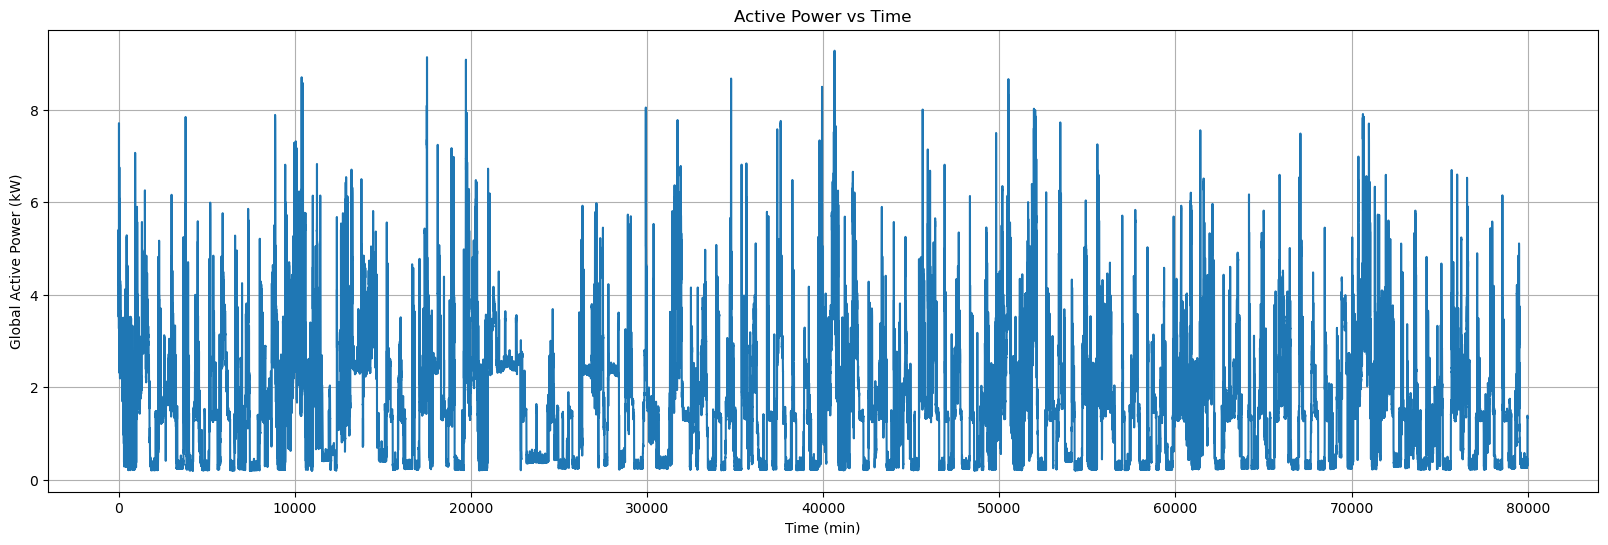

In [105]:
#Visualize the time series data

plt.figure(figsize=(20, 6))  # Width=10 inches, Height=6 inches
plt.plot(X_train, y_train)
plt.xlabel('Time (min)')
plt.ylabel('Global Active Power (kW)')
plt.title('Active Power vs Time')
plt.grid(True)
plt.show()


## Normalization and feature scaling

In [106]:
# Normalize the series using MinMaxScaler
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1)).flatten()
x_valid_scaled = scaler.transform(np.array(X_test).reshape(-1, 1)).flatten()

# Preparing Features and labels

In [107]:
# parameters
window_size = 1440
batch_size = 64
shuffle_buffer_size = 1000

def window_dataset(series, window_size, batch_size, shuffle_buffer):
    # Convert the series to a tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Create windows of size (window_size + 1) with a shift of 1
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten each window into a single batch so each window is a tensor
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Split each window into features (window[:-1]) and label (window[-1])
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    
    # Shuffle the dataset with a buffer
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Batch the dataset and use prefetching for optimized data loading
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

# Generate the training dataset using the defined function
train_set = window_dataset(x_train_scaled, window_size, batch_size, shuffle_buffer_size)
val_set = window_dataset(x_valid_scaled, window_size, batch_size, shuffle_buffer_size)


## Part 2 - Building and Training the RNN

### Build model

In [108]:
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Define the model
model = models.Sequential([
    # 1. Convolutional Layer to learn short-term patterns
    layers.Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=[window_size, 1]),
    layers.MaxPooling1D(pool_size=2),  # Optional pooling layer to reduce dimensionality
    
    # 2. LSTM Layer for capturing temporal dependencies
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(32),
    
    # 3. Dense Layers (DNN) for final prediction
    layers.Dense(32, activation="relu"),
    layers.Dense(1)  # Final output layer for regression
])

# Compile the model
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

model.summary()

c:\Users\kylea\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 1438, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 719, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 719, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,857 (69.75 KB)

 Trainable params: 17,857 (69.75 KB)

 Non-trainable params: 0 (0.00 B)

### Train Model

Epoch 1/20
   1228/Unknown 407s 327ms/step - loss: 3.2734e-05

c:\Users\kylea\anaconda3\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1228/1228 ━━━━━━━━━━━━━━━━━━━━ 443s 356ms/step - loss: 3.2730e-05 - val_loss: 0.0032
Epoch 2/20
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 472s 384ms/step - loss: 5.8477e-05 - val_loss: 0.0023
Epoch 3/20
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 438s 355ms/step - loss: 1.3724e-05 - val_loss: 0.0013
Epoch 4/20
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 442s 359ms/step - loss: 3.8189e-05 - val_loss: 0.0013
Epoch 5/20
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 437s 355ms/step - loss: 9.8283e-06 - val_loss: 0.0020
Epoch 6/20
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 438s 356ms/step - loss: 2.4114e-05 - val_loss: 0.0013
Epoch 7/20
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 436s 354ms/step - loss: 7.4908e-06 - val_loss: 8.8921e-04
Epoch 8/20
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 438s 356ms/step - loss: 5.5891e-06 - val_loss: 0.0010
Epoch 9/20
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 478s 388ms/step - loss: 1.0295e-05 - val_loss: 3.0945e-04
Epoch 10/20
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 514s 417ms/step - loss: 8.7670e-06 - val_loss: 0.0056
Epoch 11/20
1228/1228 ━━━━━━━━━━━━━━━━━━━━

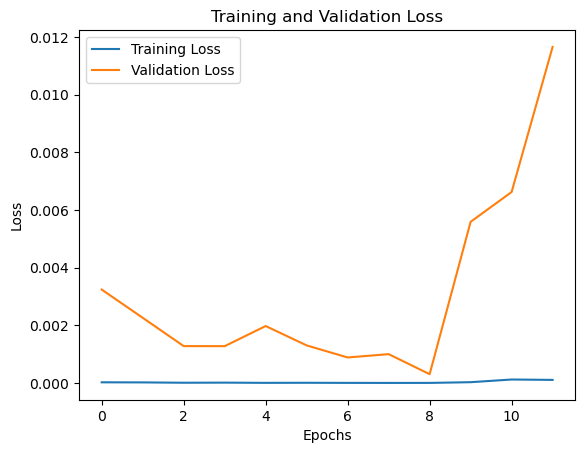

In [109]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

history = model.fit(train_set, epochs=20, validation_data=val_set, verbose=1, callbacks=[early_stopping])

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Forecasting

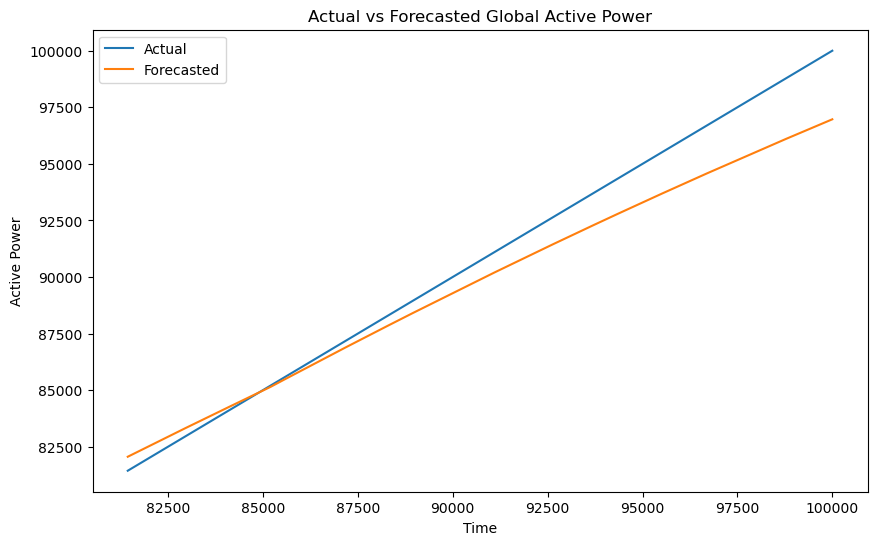

In [110]:
def model_forecast(model, series, window_size):
    series = np.array(series)
    forecast = []
    for time in range(len(series) - window_size):
        window = series[time:time + window_size]
        window = window.reshape((1, window_size, 1))
        prediction = model.predict(window, verbose=0)
        forecast.append(prediction[0, 0])
    return np.array(forecast)

# Forecasting
forecast = model_forecast(model, x_valid_scaled, window_size)

# Rescale forecasted values back to the original scale
forecast_rescaled = scaler.inverse_transform(forecast.reshape(-1, 1)).flatten()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(X_test[window_size:], X_test[window_size:], label="Actual")
plt.plot(X_test[window_size:], forecast_rescaled, label="Forecasted")
plt.title("Actual vs Forecasted Global Active Power")
plt.xlabel("Time")
plt.ylabel("Active Power")
plt.legend()
plt.show()